# Israeli COVID-19 mortality predictions, without government action, by regressions and curve-fitting binder notebook 

The following is a code notebook which accompanies research on the topic of COVID-19 mortality from MAXCOR labs. The point of the notebook is to examine a counterfactual scenario in Israel in which there was no vaccination campaign. We will examine the following topics:

[Deaths data](#section_id_0)

[Curve fitting data to think about future deaths](#section_id_0a)

[Conclusions](#section_id_1)



## Libraries used

In [2]:
# data and viz basics basics 
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import rc

# time series basics
import datetime as dt
from datetime import datetime
from datetime import date
from datetime import timedelta
from pandas.tseries.offsets import DateOffset
from calendar import monthrange

# math libraries and packages
import math as mth

#import scipy and relevant modules
import scipy 
from scipy import stats as st
from scipy.optimize import curve_fit

<a id='section_id_0'></a>
## Import, reformat and examine data on deaths from COVID-19 in Israel. Make interpolation and/or smoothed version for time series and ML needs.
All data is from the Israel Ministry of Health dashboard as retrieved on 18/9/2021 (https://datadashboard.health.gov.il/COVID-19/general)

In [3]:
# getting daily deaths from the Israel MOH dashboard on 18/09/2021 (https://datadashboard.health.gov.il/COVID-19/general)
daily_deaths = pd.read_csv('daily_deaths_from_dashboard.csv')

In [4]:
daily_deaths = daily_deaths.rename(columns = {'נפטרים - יומי': 'date','Unnamed: 1':'deaths'})
daily_deaths

,date,deaths
0,תאריך,מספר נפטרים
1,02-03-2020,0
2,03-03-2020,0
3,04-03-2020,0
4,05-03-2020,0
...,...,...
561,13-09-2021,18
562,14-09-2021,26
563,15-09-2021,18
564,16-09-2021,15


In [5]:
daily_deaths = daily_deaths[1:].copy(deep = True) 
daily_deaths['date_as_date'] = pd.to_datetime(daily_deaths.date, format= '%d-%m-%Y')
daily_deaths['deaths'] = pd.to_numeric(daily_deaths['deaths'])

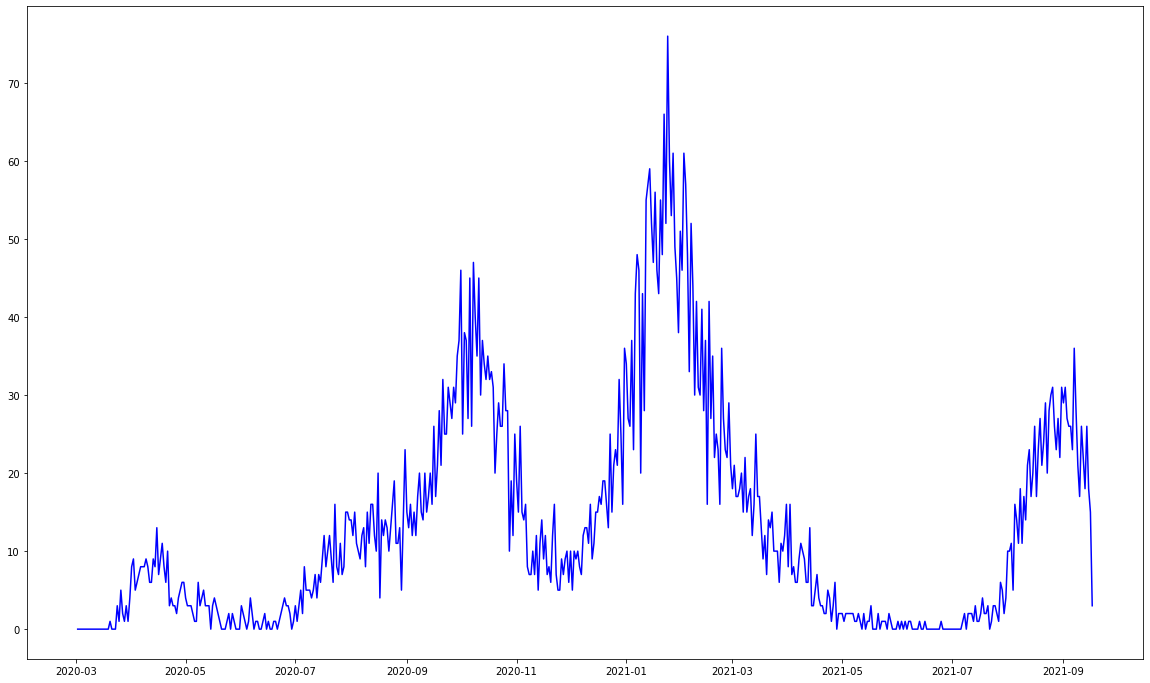

In [6]:
# graph daily deaths
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(daily_deaths['date_as_date'],
       daily_deaths.deaths,
       label='p',
       color='blue')

## Note the daily deaths data is a too jumpy to derive a realistic polynomial from. Also note the resulting polynomial will be a veru high degree if we do curve fitting here. Previous research has shown that the government responded to rising deaths with various measures including lock-downs which eventually lowered deaths. The aim of the curve fitting in this notebook will be to examine a hypothetical situation in which the government had not locked down during the third wave. Curve fitting is best suited to interpolating data between existing points, but in this case we will use the algorithm to interogate potential scenarios that did not happen.

<a id='section_id_0a'></a>
# Curve fitting

In [10]:
# prepare s dataset from December 
daily_deaths_date_indexed = daily_deaths.set_index(['date_as_date'], drop= True)
daily_deaths_date_indexed.head(5) 
deaths_after_december1 =daily_deaths_date_indexed[274:]
deaths_after_december1.head(5) 

,date,deaths
date_as_date,,
2020-12-01,01-12-2020,10
2020-12-02,02-12-2020,5
2020-12-03,03-12-2020,10
2020-12-04,04-12-2020,9
2020-12-05,05-12-2020,10


## We will make a polynomial projection based on deaths before  January 15th, after December 1st. This projection is counterfactual. In January a mass vaccination campaign began which shifted the number of infections and deaths downward. Thus the government was able to loosen restrictions. The questions these curve-fit functions adress is what might have happened if the government had still loosened restrictions in the middle of the third wave, but there was no vaccination campaign.

In [11]:
# here we cut the dataframe down to december 1st to january 15th
# and display to make sure the numbers are correct 
deaths_december1_to_jan15 = daily_deaths_date_indexed[274:320]
deaths_december1_to_jan15 =deaths_december1_to_jan15.reset_index()
deaths_december1_to_jan15

,date_as_date,date,deaths
0,2020-12-01,01-12-2020,10
1,2020-12-02,02-12-2020,5
2,2020-12-03,03-12-2020,10
3,2020-12-04,04-12-2020,9
4,2020-12-05,05-12-2020,10
5,2020-12-06,06-12-2020,8
6,2020-12-07,07-12-2020,7
7,2020-12-08,08-12-2020,12
8,2020-12-09,09-12-2020,13
9,2020-12-10,10-12-2020,13


In [12]:
 deaths_december1_to_jan15['number_days_from_d1'] = deaths_december1_to_jan15.index

In [13]:
deaths_december1_to_jan15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_as_date         46 non-null     datetime64[ns]
 1   date                 46 non-null     object        
 2   deaths               46 non-null     int64         
 3   number_days_from_d1  46 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.6+ KB


In [14]:
# load input variables from data for regression based curve fitting
x_values = deaths_december1_to_jan15.number_days_from_d1
y_values = deaths_december1_to_jan15.deaths

In [15]:
# objective linear function
def linear_objective(x, a, b):
    return a * x + b

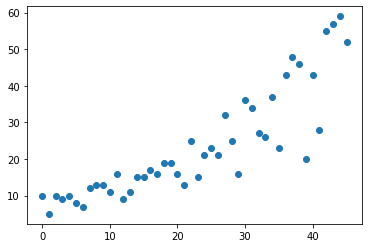

In [16]:
plt.scatter(x_values, y_values)
plt.show()

In [17]:
# curve fit to a linear regression
popt, _ = curve_fit(linear_objective, x_values, y_values)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

y = 0.95467 * x + 2.12858


## So assuming we curve fit to a linear regression we would get y = 0.95467 * x + 2.12858
## Now let's make and visualize that data

In [22]:
deaths_december1_to_jan15['linear_curve_fit']= 0.95467 *deaths_december1_to_jan15['number_days_from_d1']  + 2.12858

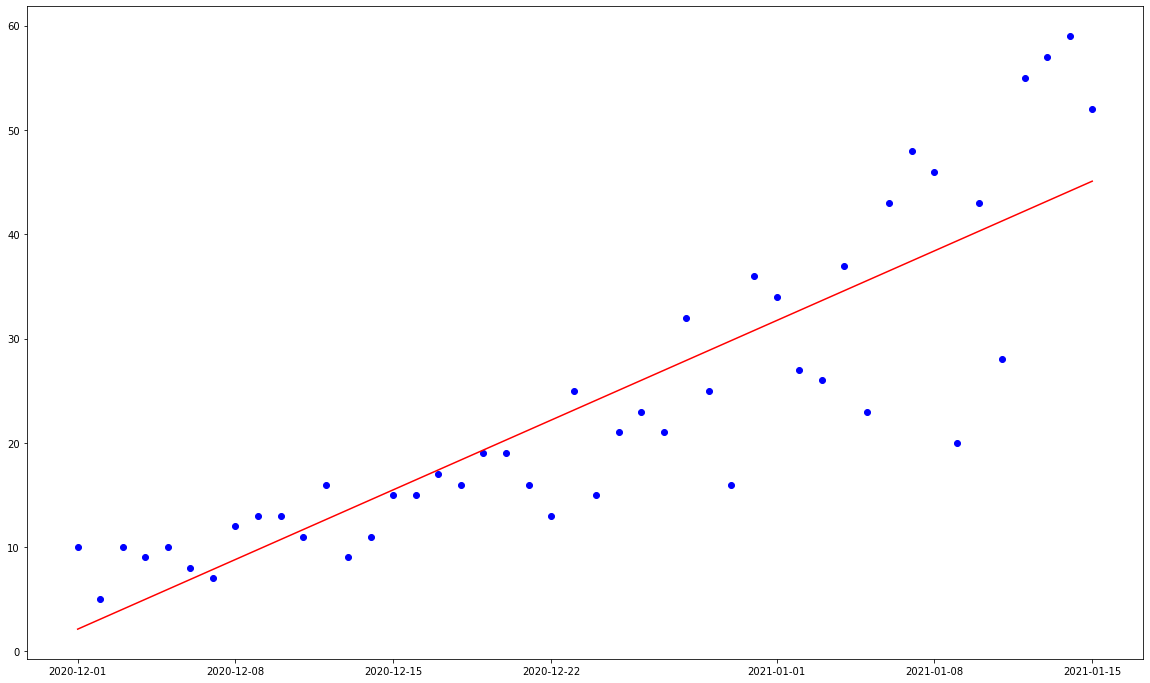

In [25]:
fig, ax = plt.subplots(figsize=(20, 12))
#Add x-axis and y-axis
ax.scatter(deaths_december1_to_jan15['date_as_date'],
       deaths_december1_to_jan15.deaths,
       label='real deaths',
       color='blue')
ax.plot(deaths_december1_to_jan15['date_as_date'],
       deaths_december1_to_jan15.linear_curve_fit,
       label='linear curve fit',
       color='red');

In [27]:
put_together = daily_deaths_date_indexed[274:]
put_together = put_together.reset_index()
put_together['number_days_from_d1'] = put_together.index 
put_together['linear_curve_fit']= 0.95467 *put_together['number_days_from_d1']  + 2.12858
put_together


,date_as_date,date,deaths,number_days_from_d1,linear_curve_fit
0,2020-12-01,01-12-2020,10,0,2.12858
1,2020-12-02,02-12-2020,5,1,3.08325
2,2020-12-03,03-12-2020,10,2,4.03792
3,2020-12-04,04-12-2020,9,3,4.99259
4,2020-12-05,05-12-2020,10,4,5.94726
...,...,...,...,...,...
286,2021-09-13,13-09-2021,18,286,275.16420
287,2021-09-14,14-09-2021,26,287,276.11887
288,2021-09-15,15-09-2021,18,288,277.07354
289,2021-09-16,16-09-2021,15,289,278.02821


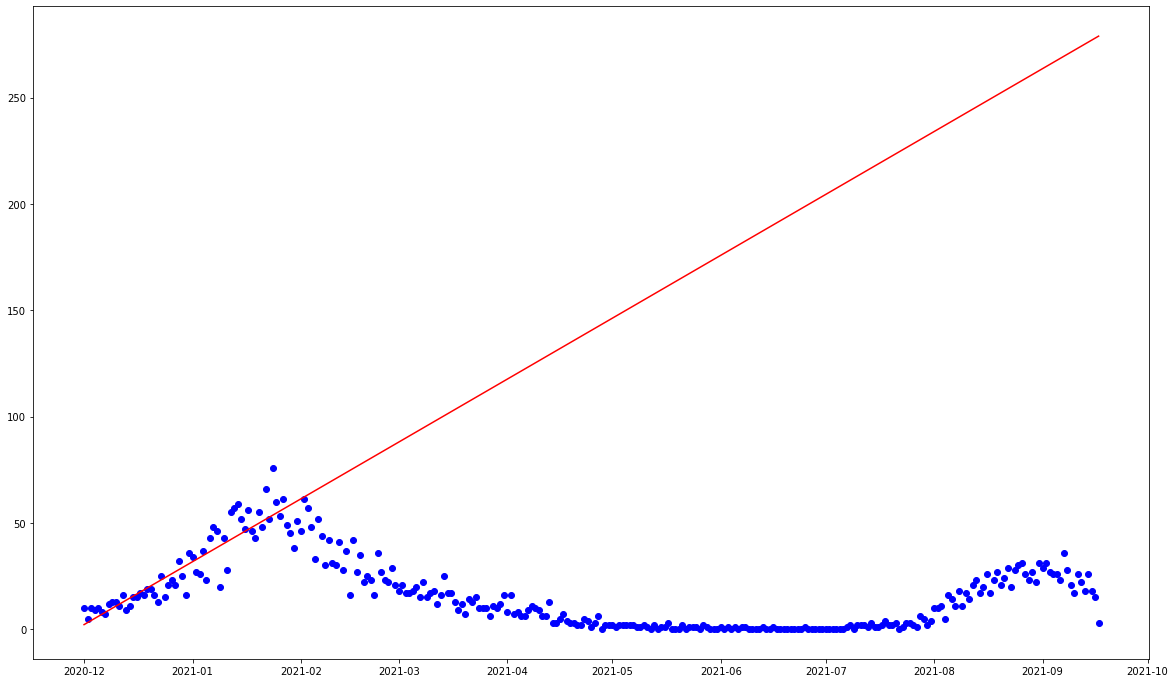

In [28]:
fig, ax = plt.subplots(figsize=(20, 12))

#Add x-axis and y-axis
ax.scatter(put_together['date_as_date'],
       put_together.deaths,
       label='real deaths',
       color='blue')
ax.plot(put_together['date_as_date'],
       put_together.linear_curve_fit,
       label='linear curve fit',
       color='red')

Now we can use our knowledge of the tabular data and the regression to  sum up deaths from March 15th - June 26th if we had linear growth

In [33]:
# we will print the tabular data to check we have the right dates
put_together[104:208]

,date_as_date,date,deaths,number_days_from_d1,linear_curve_fit
104,2021-03-15,15-03-2021,17,104,101.41426
105,2021-03-16,16-03-2021,17,105,102.36893
106,2021-03-17,17-03-2021,13,106,103.32360
107,2021-03-18,18-03-2021,9,107,104.27827
108,2021-03-19,19-03-2021,12,108,105.23294
...,...,...,...,...,...
203,2021-06-22,22-06-2021,0,203,195.92659
204,2021-06-23,23-06-2021,0,204,196.88126
205,2021-06-24,24-06-2021,0,205,197.83593
206,2021-06-25,25-06-2021,1,206,198.79060


In [34]:
# OK, so let's sum up deaths until March 14th - June 26th if we had linear growth
put_together[104:208].linear_curve_fit.sum()

15660.29556

## But we know the growth in case numbers and deaths was actually not linear. Both the actual data and theoretical work support non-linear growth of numbers infected and dead. Therefore it is more realistic to use a higher degree polynomial for curve fitting. We will do so below:

In [36]:
# load input variables from data
x_values = deaths_december1_to_jan15.number_days_from_d1
y_values = deaths_december1_to_jan15.deaths

In [37]:
# define the real objective presumably higher degree pulynomial function, and we can assume second degree
def objective(x, a, b, c):
    return a * x**2 + b * x + c

In [38]:
# curve fit
popt, _ = curve_fit(objective, x_values, y_values)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x**2 + %.5f*x + %.5f' % (a, b, c))

y = 0.02234 * x**2 + -0.05071*x + 9.50139


In [39]:
put_together['objective_curve_fit']= 0.02234 *put_together['number_days_from_d1']**2  -0.05071*put_together['number_days_from_d1'] + 9.50139
put_together

,date_as_date,date,deaths,number_days_from_d1,linear_curve_fit,objective_curve_fit
0,2020-12-01,01-12-2020,10,0,2.12858,9.50139
1,2020-12-02,02-12-2020,5,1,3.08325,9.47302
2,2020-12-03,03-12-2020,10,2,4.03792,9.48933
3,2020-12-04,04-12-2020,9,3,4.99259,9.55032
4,2020-12-05,05-12-2020,10,4,5.94726,9.65599
...,...,...,...,...,...,...
286,2021-09-13,13-09-2021,18,286,275.16420,1822.32097
287,2021-09-14,14-09-2021,26,287,276.11887,1835.07108
288,2021-09-15,15-09-2021,18,288,277.07354,1847.86587
289,2021-09-16,16-09-2021,15,289,278.02821,1860.70534


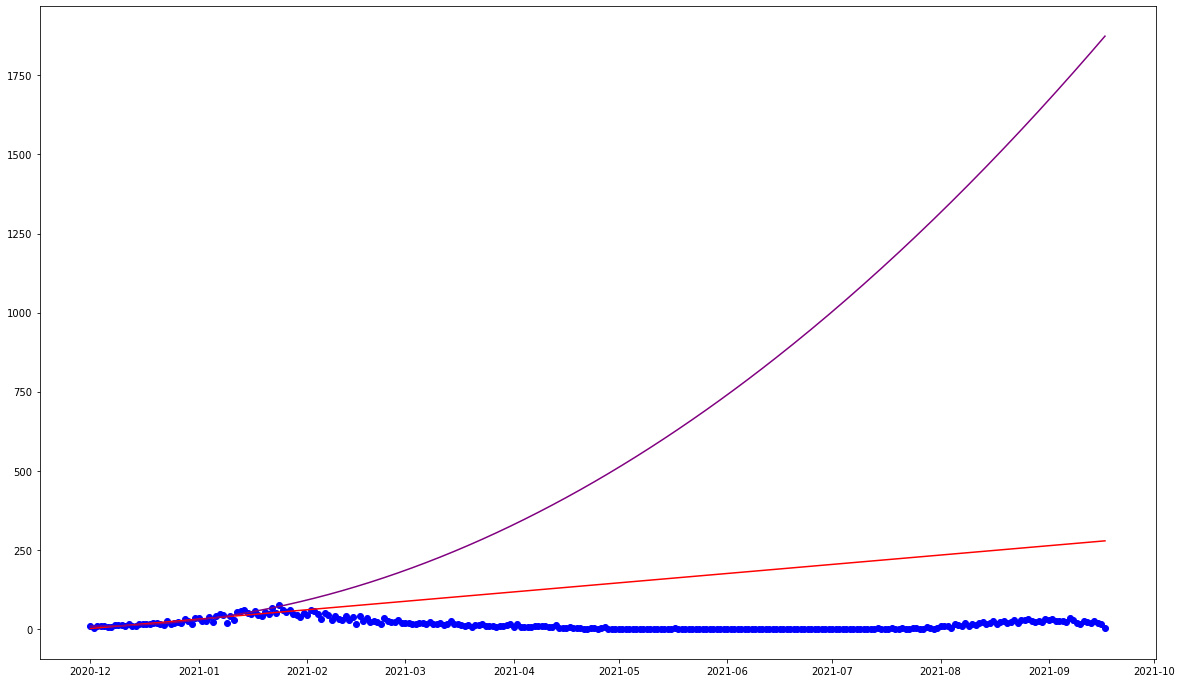

In [40]:
fig, ax = plt.subplots(figsize=(20, 12))

#Add x-axis and y-axis
ax.scatter(put_together['date_as_date'],
       put_together.deaths,
       label='real deaths',
       color='blue')
ax.plot(put_together['date_as_date'],
       put_together.linear_curve_fit,
       label='linear curve fit',
       color='red')
ax.plot(put_together['date_as_date'],
       put_together.objective_curve_fit,
       label='objective curve fit',
       color='purple')

# So assuming a second degree polynomial fit (which is probably more realistics) we would end up with an even higher number of deaths given no government interventions or vaccination campaign.

In [41]:
put_together[104:208]

,date_as_date,date,deaths,number_days_from_d1,linear_curve_fit,objective_curve_fit
104,2021-03-15,15-03-2021,17,104,101.41426,245.85699
105,2021-03-16,16-03-2021,17,105,102.36893,250.47534
106,2021-03-17,17-03-2021,13,106,103.32360,255.13837
107,2021-03-18,18-03-2021,9,107,104.27827,259.84608
108,2021-03-19,19-03-2021,12,108,105.23294,264.59847
...,...,...,...,...,...,...
203,2021-06-22,22-06-2021,0,203,195.92659,919.81632
204,2021-06-23,23-06-2021,0,204,196.88126,928.85799
205,2021-06-24,24-06-2021,0,205,197.83593,937.94434
206,2021-06-25,25-06-2021,1,206,198.79060,947.07537


In [42]:
# let's total up death from March 15th until June 26th
put_together[104:208].objective_curve_fit.sum()

58441.41628

<a id='section_id_1'></a>
# Conclusions:
# If we use a linear regression and extend it with curve fitting we predict 15,660 deaths between March 15th and June 26th. If we use a non-linear regression and extend it with curve fitting we predict 58,441 deaths  between March 15th and June 26th.
## Obviously, these numbers of deaths here predicted would not have happened in the real world. In the real world government policy and human behaviours change in response to social phenomenon. 10,000 or even 5,000 deaths over a few months would have been enough to make the Israeli government try drastic measures to stop the spread of the disease. Government lockdowns and vaccination campaigns did work to stop disease spread.  This notebook was meant to examine hypothetical deaths if modeled by regression and curve fitting assuming no government lockdowns or vaccination.

An interesting question is whether a different machine learning approach, based on more data would give us different numbers for the potential deaths without vaccination. The problem could be modeled as a multi-variate regression. We have in fact done this, but it is not presented in this notebook. 